In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
device = "cuda:4"

In [8]:
import torch
from diffusers import DDIMScheduler
from utils import load_image_data, load_image, pil_to_tensor
import matplotlib.pyplot as plt
from methods.fpe import (
    SelfAttentionControlEdit,
    register_attention_control_new,
    FreePromptPipeline,
)
import numpy as np

#### Model Construction

In [4]:
pipe = FreePromptPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", safety_checker=None
).to(device)
pipe.scheduler = DDIMScheduler(
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'fpe.FreePromptPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [5]:
image_data = load_image_data("images/data.json")
print(len(image_data))

5


a photo of a cat
a photo of a tiger


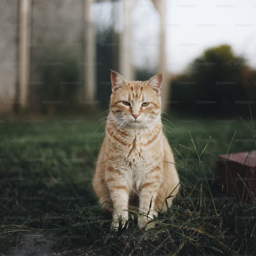

In [6]:
editing_data = image_data[4]
path, source_caption, target_caption = (
    editing_data["path"],
    editing_data["source_caption"],
    editing_data["target_caption"],
)
print(source_caption)
print(target_caption)
images = load_image(path)
images.resize((256, 256))

#### Real editing

In [9]:
# source_caption = "a cat"
# target_caption = "a egg"


source_image = pil_to_tensor(images, device)

In [10]:
self_replace_steps = 0.8
NUM_DIFFUSION_STEPS = 50

# invert the source image
start_code, latents_list = pipe.invert(
    source_image,
    source_caption,
    guidance_scale=7.5,
    num_inference_steps=50,
    return_intermediates=True,
)


latents = torch.randn(start_code.shape, device=device)
prompts = [source_caption, target_caption]

start_code = start_code.expand(len(prompts), -1, -1, -1)
controller = SelfAttentionControlEdit(
    prompts, NUM_DIFFUSION_STEPS, self_replace_steps=self_replace_steps
)

register_attention_control_new(pipe, controller)

# Note: querying the inversion intermediate features latents_list
# may obtain better reconstruction and editing results
results = pipe(
    prompts,
    latents=start_code,
    guidance_scale=7.5,
    ref_intermediate_latents=latents_list,
)

DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  4.97it/s]


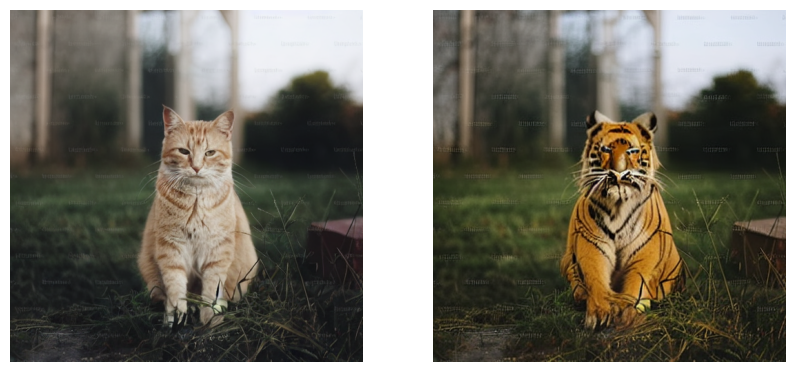

In [11]:
def plot_results(images):
    images = images.cpu().permute(0, 2, 3, 1).numpy()
    images = (images * 255).astype(np.uint8)


    # Plot the images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.axis('off')
    plt.show()

plot_results(results)